# Royal Caribbean Data Analytics & AI Assessment

<u>Candidate Name:</u> Justin Bell  
<u>Date Completed:</u> March 5, 2023

## Part 1: SQL Queries

The relational database used for answering questions in this part is shwon below.

from IPython.display import Image
Image(filename='relational_db.png')
<center><img src="relational_db.png"/></center>

### Q1: Report the total number of sales orders processed last month. (The month before current). Today’s date is 2020-01-23.

In [1]:
# Define the parameters for the query.
params = {
    "PARAM_SALES_ORDER": "fact_sales_order",  # Table name for sales orders.
    "PARAM_MONTH": "December",  # Month for which to count sales.
    "PARAM_YEAR": 2019  # Year for which to count sales.
}

# SQL query using f-string so parameters can be easily changed.
query = f'''
SELECT COUNT(sales_order_number) AS total_number_sales
FROM {params['PARAM_SALES_ORDER']}
LEFT JOIN dim_date
USING (date_key)
WHERE dim_date.month_name = '{params['PARAM_MONTH']}'
    AND dim_date.year = {params['PARAM_YEAR']}
'''

### Q2: Rank my store sales (sale_subtotal) based on sales that occured last month. (The month before current). Today’s date is 2020-01-23. Please report the store name and city the store is located in your query.

In [2]:
from datetime import datetime as dt

params = {
    "PARAM_SALES_ORDER": "fact_sales_order", # Table name for sales orders.
    "PARAM_DATE": dt(2020, 1, 23) # Current date.
}
query = f"""
SELECT b.store_name, b.city,
    RANK() OVER (ORDER BY COALESCE(a.store_sales, 0) DESC) AS sales_rank
FROM (
    SELECT store_key, SUM(sale_subtotal) AS store_sales
    FROM {params['PARAM_SALES_ORDER']}
    LEFT JOIN dim_date
    USING (date_key)
    WHERE EXTRACT(MONTH FROM dim_date.date_key) = 
        CASE
            WHEN DATE '{params['PARAM_DATE']}' >= DATE '{params['PARAM_DATE'].year}-02-01' THEN 1
            ELSE EXTRACT(MONTH FROM ADD_MONTHS(DATE '{params['PARAM_DATE']}', -1))
        END
        AND EXTRACT(YEAR FROM dim_date.date_key) = 
        CASE
            WHEN EXTRACT(MONTH FROM dim_date.date_key) = 1 AND DATE '{params['PARAM_DATE']}' < DATE '{params['PARAM_DATE'].year}-01-01' THEN {params['PARAM_DATE'].year} - 1
            ELSE {params['PARAM_DATE'].year}
        END
    GROUP BY store_key
) AS a
RIGHT JOIN dim_store AS b
USING (store_key)
"""

### Q3: Since the beginning of this year, which employee has the most unique sales?

In [3]:
params = {
    "PARAM_SALES_ORDER": "fact_sales_order",  # Table name for sales orders.
    "PARAM_YEAR": 2020 # Year for which to count sales.
}

query = f'''
SELECT b.employee_name
FROM (
    SELECT employee_key, COUNT(sales_order_number) AS employee_sales_count
    FROM {params['PARAM_SALES_ORDER']}
    LEFT JOIN dim_date
    USING (date_key)
    WHERE dim_date.year = {params['PARAM_YEAR']}
    GROUP BY employee_key
) AS a
LEFT JOIN dim_employee AS b
USING (employee_key)
ORDER BY employee_sales_count DESC
LIMIT 1
'''

## Part 2: Exploratory Data Analysis

In the zip file you will find a dataset called satistfaction.csv This dataset contains information
about airline passengers, their trip, and whether or not they were satisfied. This data is from
a survey so make the assumption that a higher number is better in columns like ‘Ease of Online
booking’. The satisfied_v2 column is something that is a verified customer sentiment via customer
service representatives reaching out to the customer.  

**Your business leaders have asked you to investigate how big of a problem we have with
unsatisfied passengers as well as what might be causing it.**  

In this part, we ask that you perform an exploratory data analysis into the dataset while also
trying to answer the business leaders’ question. Feel free to be as concise or as thorough as you’d
like.

First, we'll do some data cleaning before making visuals.

In [4]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Read in excel data and view first few rows.
df = pd.read_excel(r'satisfaction.xlsx')
df.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,117135,satisfied,Male,disloyal Customer,56,Personal Travel,Eco,369,0,2,...,3,3,1,5,3,3,4,3,0,0.0
1,72091,satisfied,Male,disloyal Customer,49,Personal Travel,Eco,2486,0,2,...,3,2,1,1,4,4,3,2,0,0.0
2,29663,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,1448,0,3,...,3,3,3,5,3,2,3,3,0,0.0
3,81849,satisfied,Female,disloyal Customer,36,Personal Travel,Eco,1501,0,4,...,4,4,5,4,5,5,5,4,0,0.0
4,83693,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,577,0,5,...,3,3,3,4,5,3,4,3,0,0.0


In [6]:
# Check size of data.
df.shape

(129880, 24)

Looks like everything was imported correctly.

In [7]:
# Check data types for each feature.
df.dtypes

id                                     int64
satisfaction_v2                       object
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

All of our features appear to have the correct data type assigned to them.

In [8]:
# View number of unique values for each feature.
df.nunique()

id                                   129880
satisfaction_v2                           2
Gender                                    2
Customer Type                             2
Age                                      75
Type of Travel                            2
Class                                     3
Flight Distance                        3821
Inflight wifi service                     6
Departure/Arrival time convenient         6
Ease of Online booking                    6
Gate location                             6
Food and drink                            6
Online boarding                           6
Seat comfort                              6
Inflight entertainment                    6
On-board service                          6
Leg room service                          6
Baggage handling                          5
Checkin service                           6
Inflight service                          6
Cleanliness                               6
Departure Delay in Minutes      

Everything looks good here. It's worth noting that the 'Baggage handling' feature has ones less unique value than the other 0-5 scale features. This most likely means that the 'Baggage handling' feature does not have any zeros. Let's check this.

In [9]:
# View counts of each value for the Baggage handling feature.
df['Baggage handling'].value_counts()

4    46761
5    33878
3    25851
2    14362
1     9028
Name: Baggage handling, dtype: int64

As hypothesized, 'Baggage handling' does not contain any scores of 0. We'll assume that this wasn't an option in the survey. Next, let's take a look to see if our data has any null values and determine the appropriate action to handle them.

In [10]:
# Check to see which columns, if any, have null values and how many there are.
df_nulls = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
df_nulls.columns = ['count', '%']
df_nulls.sort_values(by=['count', '%'], ascending=False)

,count,%
Arrival Delay in Minutes,393,0.302587
id,0,0.000000
satisfaction_v2,0,0.000000
Gender,0,0.000000
Customer Type,0,0.000000
Age,0,0.000000
Type of Travel,0,0.000000
Class,0,0.000000
Flight Distance,0,0.000000
Inflight wifi service,0,0.000000


Fortunately, most of our features don't have any missing values! Even better, the only feature that does, 'Arrival Delay in Minutes', has very few relative to the size of our dataset. Since 0.30% is very small, we will simply drop these rows for our analysis rather than impute values.

In [11]:
# Drop all rows with null values and check the size of our new dataframe.
df = df.dropna()
df.shape

(129487, 24)

Now our data has no missing values. It's also worth noting that we are not worried about duplicates because the id column is unique. Let's now split our data by 'satisfaction_v2' and start creating some visuals to help us better understand our data.

In [12]:
# Splitting data by 'satisfaction_v2'.
df_s = df[df['satisfaction_v2']=='satisfied']
df_d = df[df['satisfaction_v2']=='neutral or dissatisfied']

In [13]:
# Check to make sure all data is split properly.
df_s.shape[0] + df_d.shape[0]

129487

This looks good. Let's take a look at some descriptive statistics for our data.

In [14]:
# View descriptive statistics for numerical features.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,129487.0,64958.335169,37489.781165,1.0,32494.5,64972.0,97415.5,129880.0
Age,129487.0,39.428761,15.117597,7.0,27.0,40.0,51.0,85.0
Flight Distance,129487.0,1190.210662,997.560954,31.0,414.0,844.0,1744.0,4983.0
Inflight wifi service,129487.0,2.728544,1.329235,0.0,2.0,3.0,4.0,5.0
Departure/Arrival time convenient,129487.0,3.057349,1.526787,0.0,2.0,3.0,4.0,5.0
Ease of Online booking,129487.0,2.756786,1.401662,0.0,2.0,3.0,4.0,5.0
Gate location,129487.0,2.976909,1.278506,0.0,2.0,3.0,4.0,5.0
Food and drink,129487.0,3.204685,1.329905,0.0,2.0,3.0,4.0,5.0
Online boarding,129487.0,3.252720,1.350651,0.0,2.0,3.0,4.0,5.0
Seat comfort,129487.0,3.441589,1.319168,0.0,2.0,4.0,5.0,5.0


These values make sense for the features overall. The only thing that stands out is the minimum 'Flight Distance' being 31.0 miles, which is rather small, albeit possible.

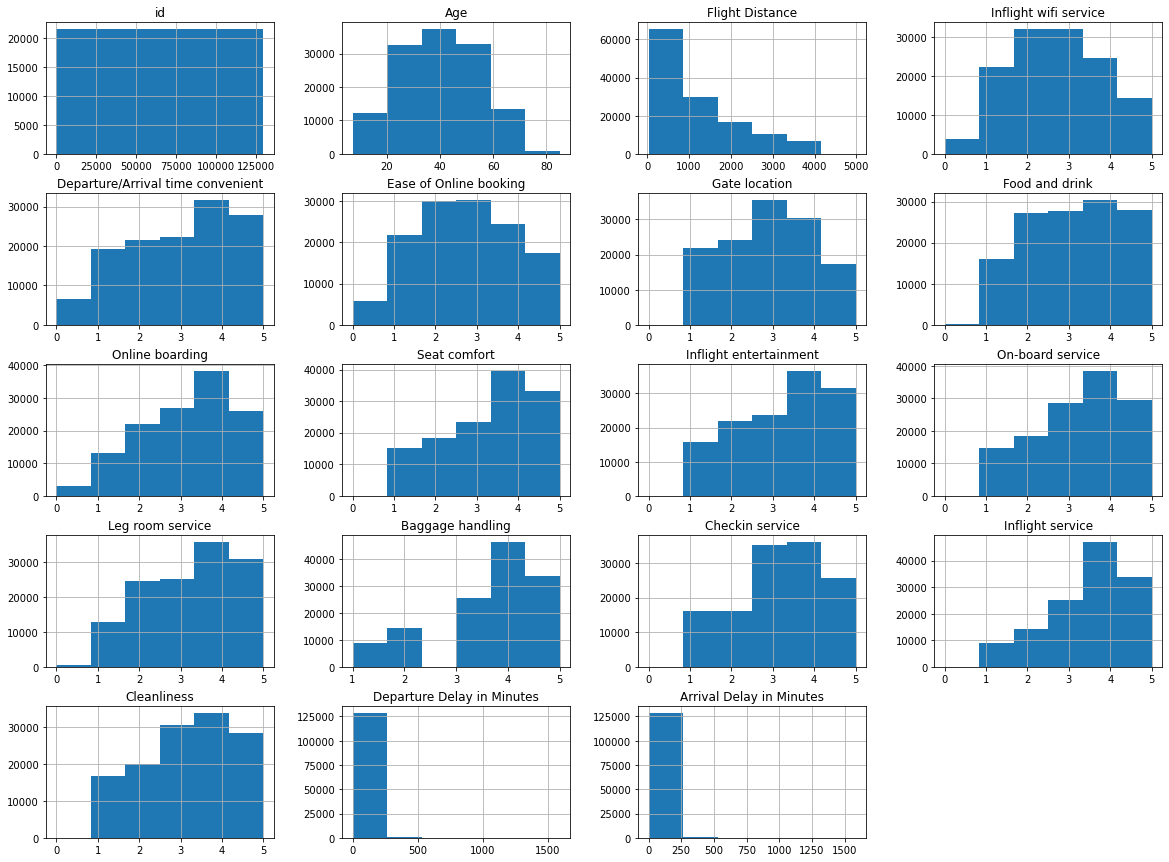

In [15]:
# Histogram for all numerical features in our pre-split data.
_ = df.hist(bins = 6, figsize = (20,15)) # Chose 6 bins for the many features with values 0-5.

It looks like we have some potential outliers for 'Flight Distance', 'Departure Delay in Minutes', and 'Arrival Delay in Minutes'. Let's take a closer look at these distributions by building some boxplots with our split data.

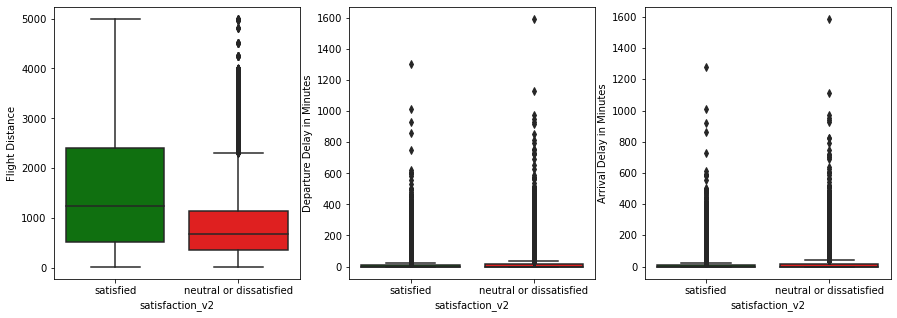

In [16]:
# Side-by-side boxplots by 'satisfaction_v2'.
fig, ax = plt.subplots(1, 3, figsize = (15,5))

colors = ['green', 'red']
_ = sns.boxplot(ax = ax[0], x = 'satisfaction_v2', y = 'Flight Distance', data = df, palette = colors)
_ = sns.boxplot(ax = ax[1], x = 'satisfaction_v2', y = 'Departure Delay in Minutes', data = df, palette = colors)
_ = sns.boxplot(ax = ax[2], x = 'satisfaction_v2', y = 'Arrival Delay in Minutes', data = df, palette = colors)

The outliers here are determined by $Q1-(1.5 * IQR)$ and $Q3+(1.5 * IQR)$.

In regards to 'Flight Distance', we can see that for satisfied customers there are no outliers. The outliers for neutral or dissatisfired customers are feasible, as they fall in the same range as satisfied customers. For the delay features, it makes sense that there would be many outliers due to most flights not being delayed at all, resulting in a value of 0. These values are also feasible, so we can leave them as is.

Let's take a quick look at the boxplots for 'Age'.

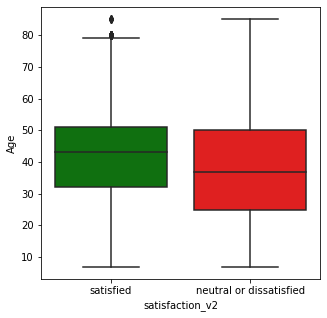

In [17]:
# Side-by-side boxplot for 'Age' by 'satisfaction_v2'.
fig, ax = plt.subplots(figsize=(5, 5))

_ = sns.boxplot(x = 'satisfaction_v2', y = 'Age', data = df, palette = colors)

Age doesn't seem to have too much of an impact on customer satisfaction, but younger people tend to be more neutral or dissatisfied thand older people. The outliers for satisfied customers are certainly feasible and will be left in.

In [18]:
# Create dataframes with only likert scale variables.
df_s_likert = df_s.drop(columns=['id', 'satisfaction_v2', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'])
df_d_likert = df_d.drop(columns=['id', 'satisfaction_v2', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'])

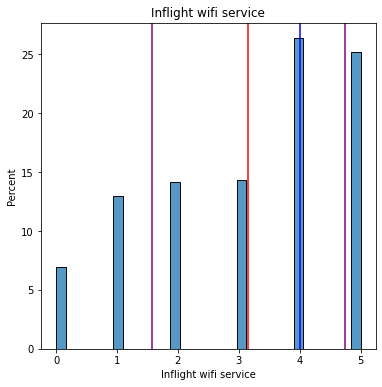

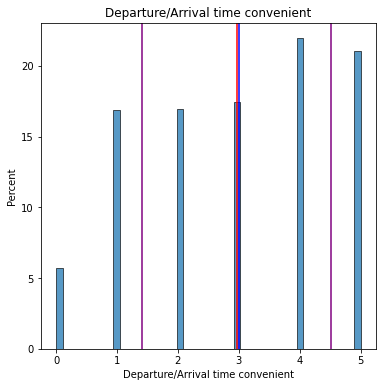

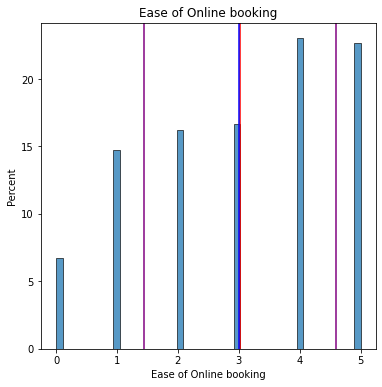

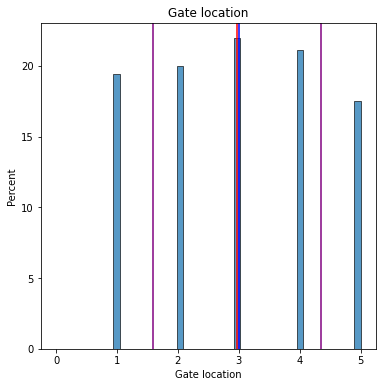

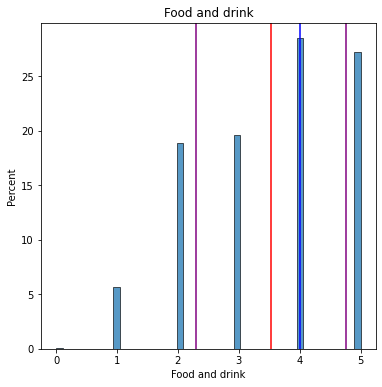

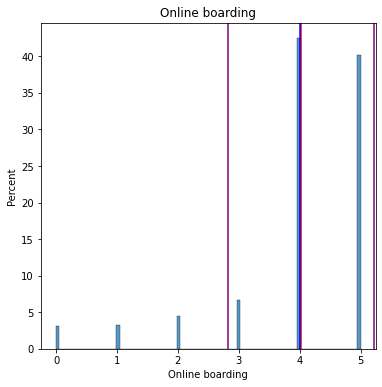

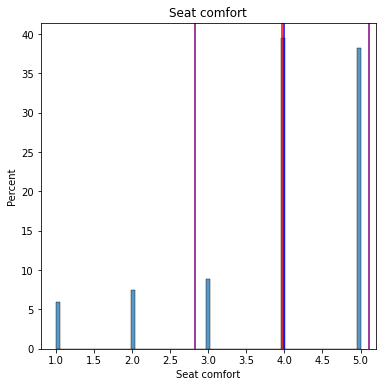

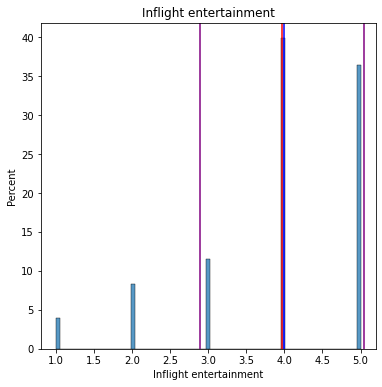

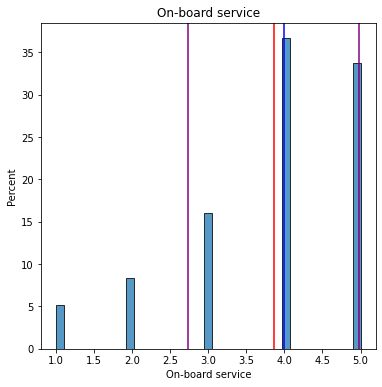

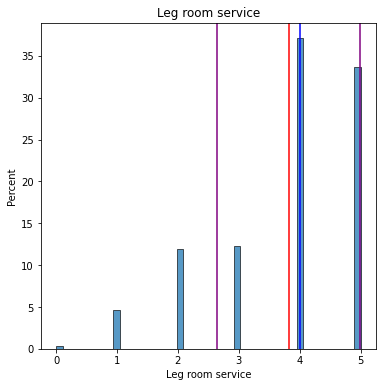

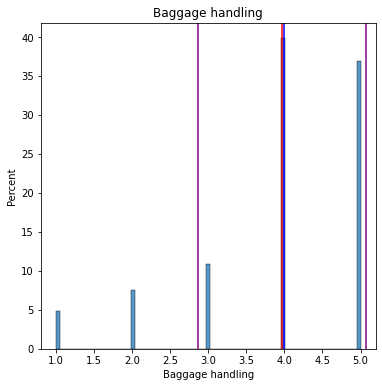

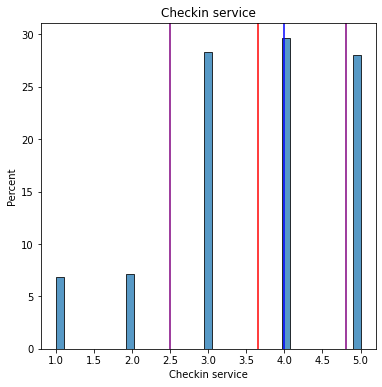

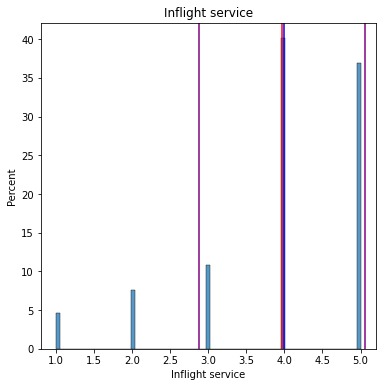

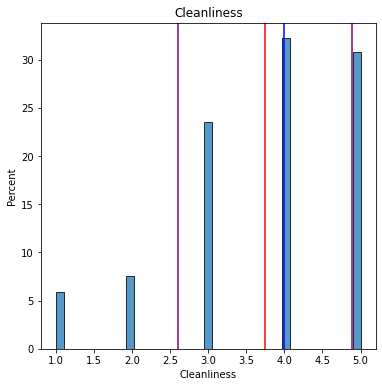

In [19]:
# Define a function that plots histograms with descriptive statistics.
def plot_dist(data):
    
    """plots histograms of data distribution with lines for mean, median, and std 
    inputs 
    df
    returns plots of distribution """
    import matplotlib.pyplot as plt
    import seaborn as sns 
    for i in data.columns:
        try:
            plt.figure(figsize=(6,6))
            sns.histplot(data[i],stat='percent')
            plt.axvline(x= data[i].mean(),color='red')
            plt.axvline(x= data[i].median(),color='blue')

            plt.axvline(x= (data[i].mean() + data[i].std()),color='purple')
            plt.axvline(x= (data[i].mean() - data[i].std()),color='purple')

            plt.title(i)
            plt.show()
        except TypeError :
            continue

# Plot histograms for satisfied likert data.
plot_dist(df_s_likert)

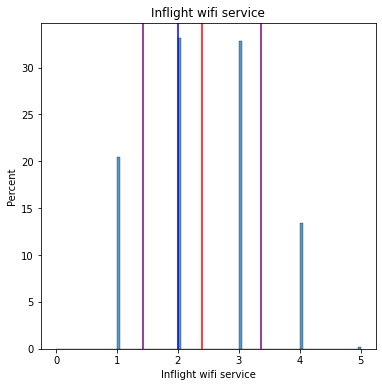

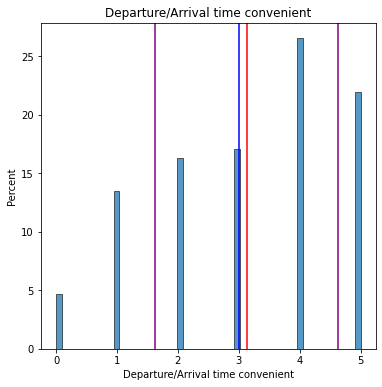

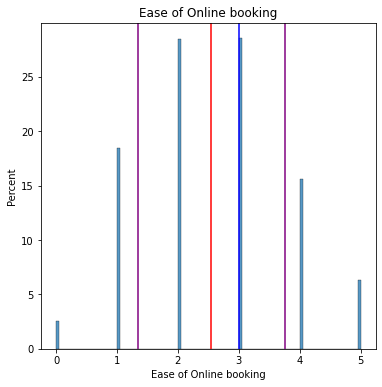

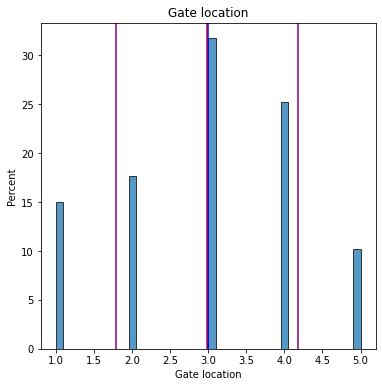

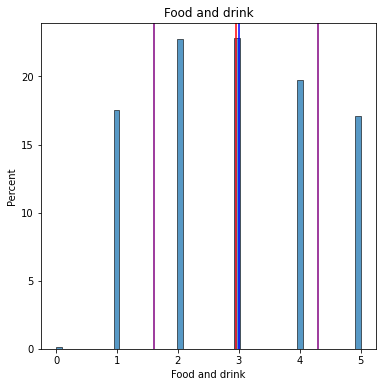

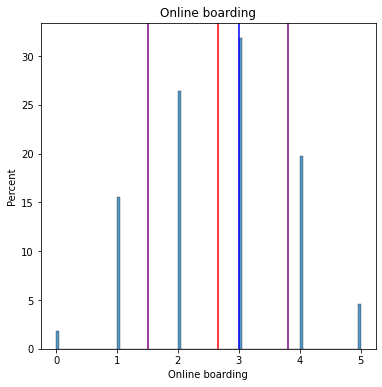

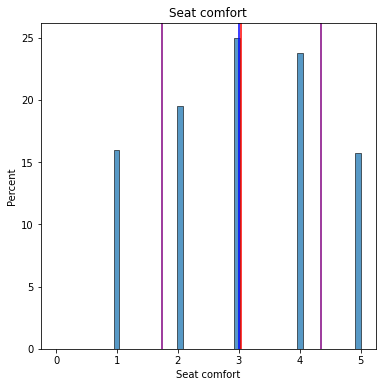

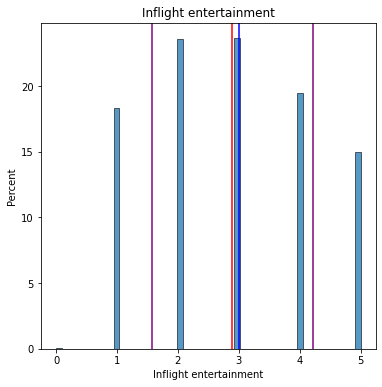

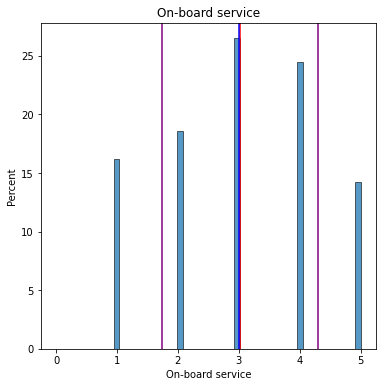

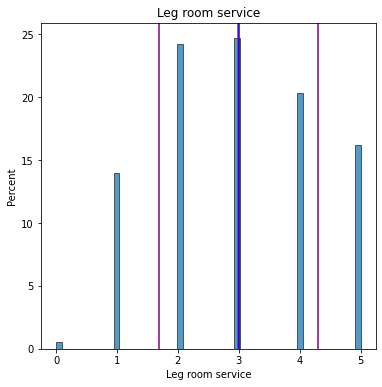

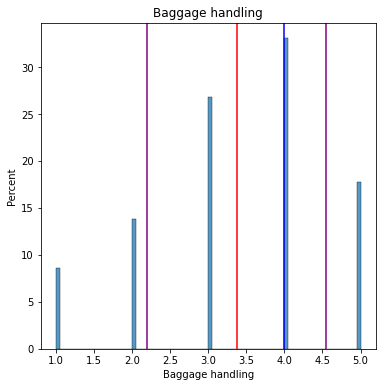

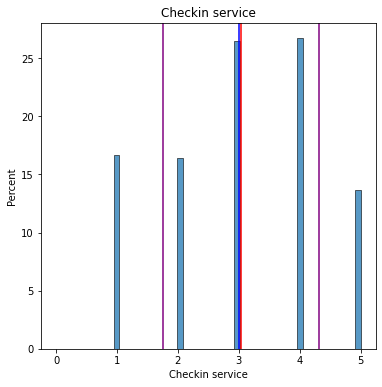

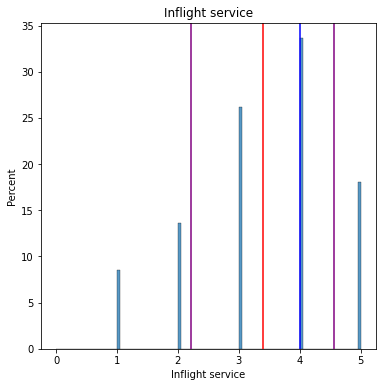

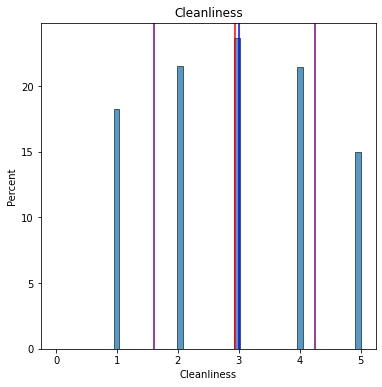

In [20]:
# Plot histograms for neutral or dissatisfied likert data.
plot_dist(df_d_likert)

The plots above show some clear differences in distributions. For example, inflight wifi service seems to be indicative of whether or not a customer is satisfied. Comparing the plots we can see that over 50% of satisfied customers rated inflight wifi service a 4 or 5, while under 15% did the same when looking at neutral or dissatisfied customers.

We also can see that there are different distributions for online boarding ratings, with nearly 80% of satisfied customers giving a rating of 4 or 5, and roughly 25% of neutral or dissatisfied customers giving the same ratings.

One other notable comparison is inflight entertainment. Satisfied customers tend to give very high scores while neutral or dissatisfied customers' ratings form more of a uniform distribution. I would expect that these three features particulary contribute to customer satisfaction more than most others.

Now, let's take a look at our categorical features and how they compare based on customer satisfaction.

C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\justi\anaconda3\lib\si

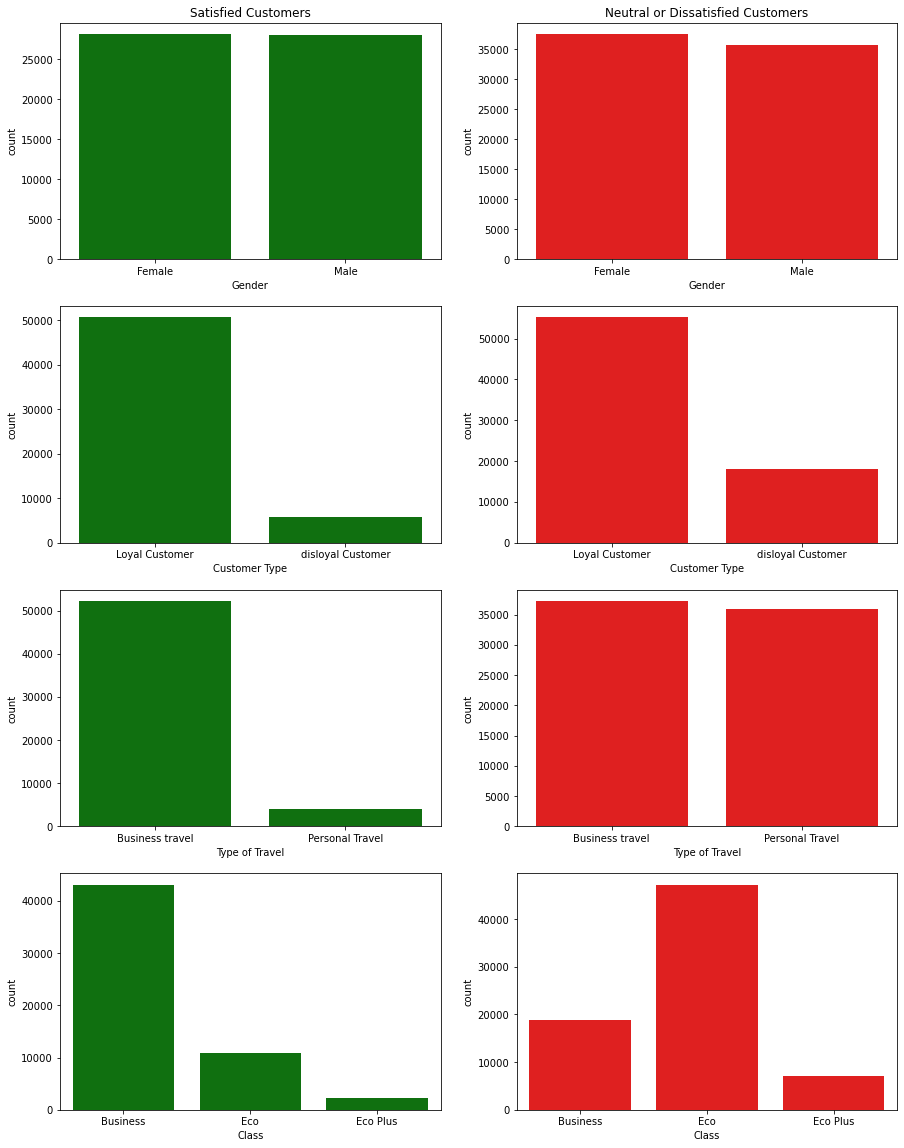

In [21]:
# Side-by-side countplots by 'satisfaction_v2'.
fig, ax = plt.subplots(4, 2, figsize = (15,20))

_ = sns.countplot(df_s['Gender'].sort_values(), ax=ax[0,0], palette=['green'])
_ = sns.countplot(df_d['Gender'].sort_values(), ax=ax[0,1], palette=['red'])
_ = sns.countplot(df_s['Customer Type'].sort_values(), ax=ax[1,0], palette=['green'])
_ = sns.countplot(df_d['Customer Type'].sort_values(), ax=ax[1,1], palette=['red'])
_ = sns.countplot(df_s['Type of Travel'].sort_values(), ax=ax[2,0], palette=['green'])
_ = sns.countplot(df_d['Type of Travel'].sort_values(), ax=ax[2,1], palette=['red'])
_ = sns.countplot(df_s['Class'].sort_values(), ax=ax[3,0], palette=['green'])
_ = sns.countplot(df_d['Class'].sort_values(), ax=ax[3,1], palette=['red'])
ax[0,0].title.set_text('Satisfied Customers')
ax[0,1].title.set_text('Neutral or Dissatisfied Customers')

Gender doesn't appear to have much of an impact on customer satisfaction. Disloyal customers are slightly more likely to be neutral or dissatisfied. Personal travel customers are much more likely to be neutral or dissatisfied. Business class customers are more likely to be satisfied, while Economy class customers are more likely to be neutral or dissatisfied. Economy plus customers are slightly more likely to be neutral or dissatisfied.

C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


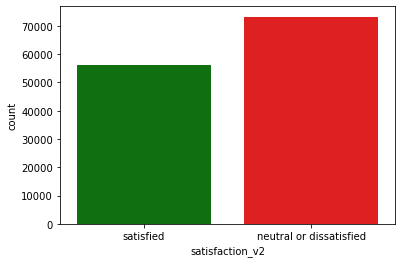

In [22]:
# Let's take a look at the distribution of our target, 'satisfaction_v2'.
_ = sns.countplot(df['satisfaction_v2'], palette=['green','red'])

Our target is not perfectly balanced, but it's not too imbalanced either. Clearly a problem exists as there are more neutral or dissatisfied customers than satisfied.

<AxesSubplot:>

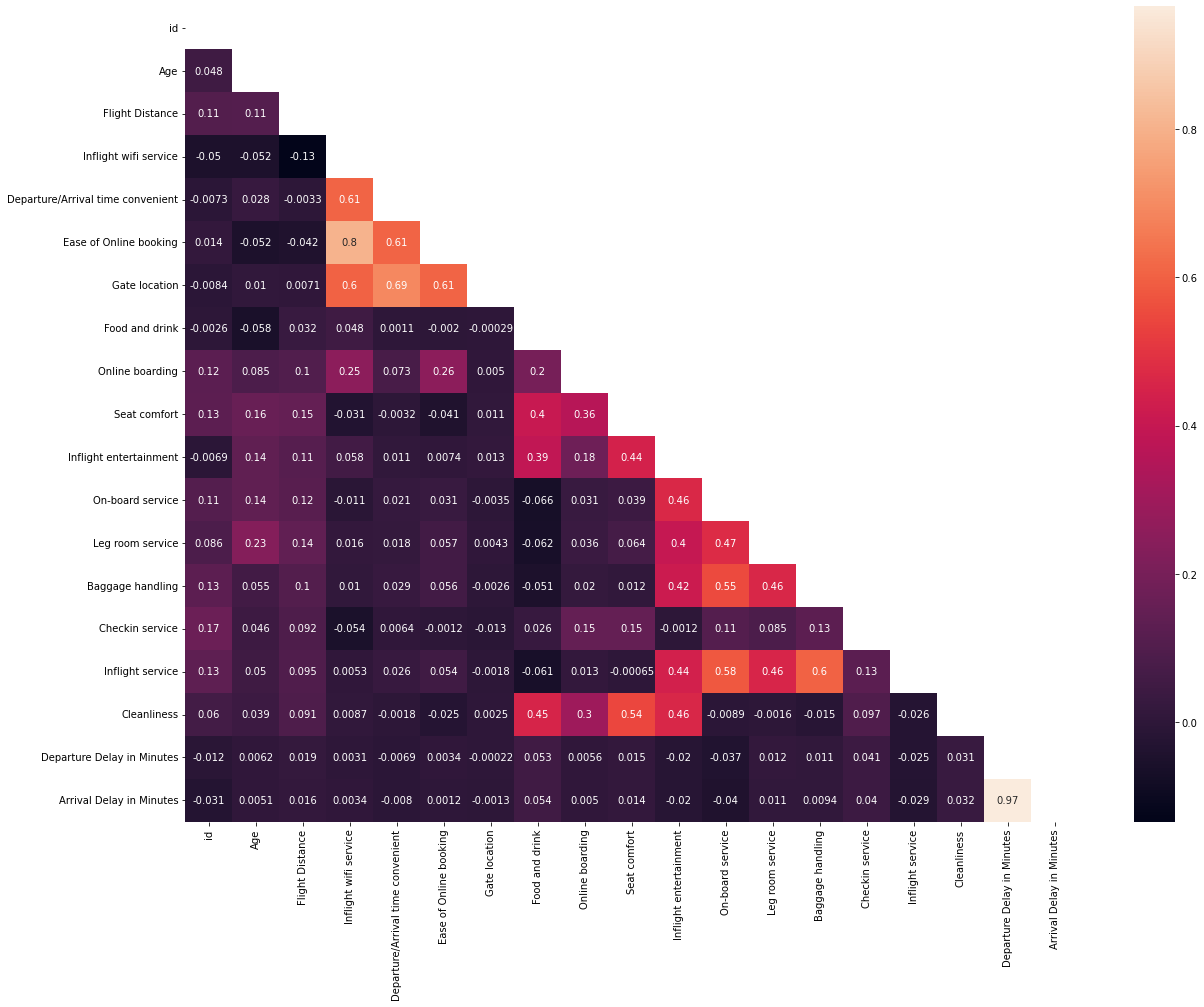

In [23]:
# Correlation heatmap for satisfied customer features.
fig, ax = plt.subplots(figsize = (20,15))
corr = df_s.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df_s.corr(), annot = True, mask=mask)

<AxesSubplot:>

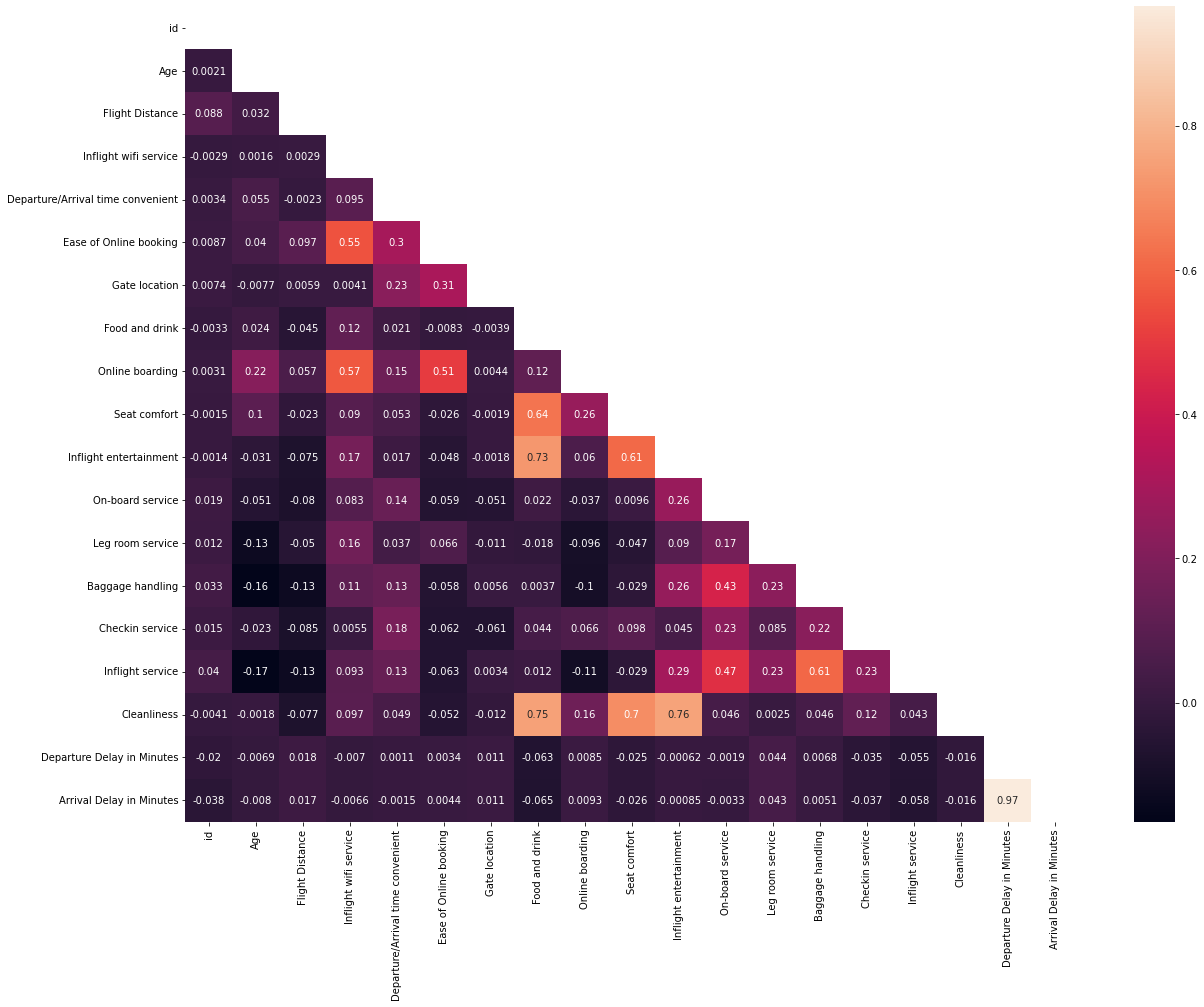

In [24]:
# Correlation heatmap for neutral or disssatisfied customer features.
fig, ax = plt.subplots(figsize = (20,15))
corr = df_d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df_d.corr(), annot = True, mask=mask)

Luckily, our data doesn't seem to have to many correlated variables, which means multi-collinearity should not be too much of a concern. There are two featues correlated highly with each other: 'Departure Delay in Minutes' and 'Arrival Delay in Minutes'. This makes logical sense as if the departure for a flight is delayed, so will the arrival. We should remove one of these features before modeling. Let's do that now.

In [25]:
# Drop one of the two correlated features.
df = df.drop(['Arrival Delay in Minutes'], axis=1)
print(df.shape)

(129487, 23)


Going into the modeling stage we have a good understanding of our data and which features may help predict customer satisfaction well.

## Part 3: Modeling

The business leaders were impressed with the analysis.  

**They now want you to build a model
that can predict if a customer was not satisfied by their flight immediately after they submit a
survey. Customer service representatives are very busy so we need to prioritize who to reach
out to first.**  

- Using the data, build the best model you can given the data that does what the business
leaders are asking. Does this business case influence the model you ended up choosing? Be
sure to explain!
- How accurate is this model? (Use whatever accuracy metrics you think are relevant.)

Be sure to explain any assumptions you make and show all steps you took to get to your final
model.

First, we'll need to preprocess our data. Scaling our data is not necessary due to the size and distribution of the values.

In [26]:
# Convert target to have values of 0 and 1.
df['satisfaction_v2'] = df['satisfaction_v2'].str.replace('satisfied', '1')
df['satisfaction_v2'] = df['satisfaction_v2'].str.replace('neutral or dissatisfied', '0')
df['satisfaction_v2'] = df['satisfaction_v2'].str.replace('neutral or dis1', '0')

In [27]:
# Check value counts for target.
df['satisfaction_v2'].value_counts()

0    73225
1    56262
Name: satisfaction_v2, dtype: int64

In [28]:
# Convert target values to integers.
df['satisfaction_v2'] = df['satisfaction_v2'].astype('int')

In [29]:
# Create dummy variables for categorical features.
df_cat = pd.get_dummies(df.drop(df['satisfaction_v2']))

In [30]:
# Define a function for splitting our data into train and test sets.
def split(df , column):
    
    """ splits the data set to x and y then over sample the imbalanced data 
    inputs 
    df pd.datafrme
    column  str(column)
    over_sample   (Boolean )
    Returns x_train,x_test,y_train,y_test """
    
    
    from sklearn.model_selection import train_test_split
    import numpy as np
    import pandas as pd 

    
    X,y=df.drop(columns=[column]),df[column]

    x_train,x_test,y_train,y_test= train_test_split(X, y, test_size=0.25, random_state=42)
    
    
    return x_train,x_test,y_train,y_test

In [31]:
# Define a function for plotting the confusion matrix.
def plot(y_test, pred):
    
        """plots the confusion matrix of given classification problem 
        Inputs :
        Y_test  pd.series 
        pred np.array 
        
        returns plot of conusion matrix """
        import numpy as np
        import pandas as pd 

        
        from sklearn.metrics import confusion_matrix
        cf_matrix = confusion_matrix(y_test, pred)
        print (cf_matrix)
        plt.figure(figsize=(8,8))

        group_names = ['True Neg','False Pos','False Neg','True Pos']

        group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
        
        group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
        
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
        
        labels = np.asarray(labels).reshape(2,2)
        
        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
        plt.show()

In [32]:
# Define a function for modeling using LogisticRegression.
def pred (x_train,x_test,y_train,y_test):
    
    """Performs logistic regression on dataset with pipeline that does scaling the regression 
    Inputs 
    x_train pd.dataframe or series 
    y_train pd.dataframe or series
    x_test pd.dataframe or series
    y_test pd.dataframe or series
    
    Returns preds (predictions ) preds_proba (predictions probability)
    """
    import numpy as np
    import pandas as pd 

    from sklearn.pipeline import make_pipeline

    from sklearn.linear_model import LogisticRegression

    from sklearn.preprocessing import StandardScaler

    from sklearn.metrics import mean_absolute_error as mae , mean_squared_error as mse , r2_score


    scale=StandardScaler
    reg=LogisticRegression

    pipe = make_pipeline(scale(), reg(class_weight= {0: 1.0, 1: 1.0}, solver="saga"))

    pipe.fit(x_train,y_train)

    pred=pipe.predict(x_test)
    
    preds_proba= pipe.predict_proba(x_test)

    print ( "Score train : " + str(pipe.score(x_train, y_train)))
    print ("R2 test : " + str( r2_score(y_test,pred)))

    from sklearn.metrics import classification_report as cr
    print (cr(y_test,pred))
    
 
    return  pred, preds_proba

In [33]:
# Define a function for a LogisticRegression pipeline.
def LR (df, column ):
    """full pipeline zero to hero to perform logistic regression
    inputs :
    df pd.dataframe 
    column column name
    returns preds (predictions ) preds_proba (predictions probability )"""
    
    x_train, x_test, y_train, y_test = split (df , column)
    
    preds, preds_proba=pred(x_train,x_test,y_train,y_test)
    
    plot(y_test,preds)
        
    
    return preds, preds_proba

In [35]:
# Define a function for modeling using RandomForest.
def forrests(df,column, get_params ,over):

    """performs Random Forrests modeling
    inputs:
    df = pd.dataframe 
    column= str(target column)
    over= "y" over samples default None
    get_params= "y" performs gridsearch then pick best model """
    #importing necessary classes
    from sklearn.ensemble import RandomForestClassifier as rf
    from sklearn.ensemble import BaggingClassifier as bc
    from sklearn.pipeline import Pipeline
    # using own function to perform the split (.07 train, random_state= 42) with option of balancing data 
    if over=="y":
        x_train, x_test, y_train, y_test= split_over(df,column)
    else:
        x_train, x_test, y_train, y_test= split(df,column)
    

        #declaring the model
    model=rf()
        #extracting the best parameters from the output of the gridsearch to use on the declared
        
    if get_params=="y" :
        
        from sklearn.model_selection import GridSearchCV as gs
        
        param_grid = { 'n_estimators':[200,500],
            "class_weight":[{0:0.25,1:1}],
            "min_impurity_decrease":[0.0],
            'max_features': ['sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
            }
        
        from sklearn import metrics
        
        scorer = metrics.make_scorer(metrics.recall_score)
        
        g=gs(estimator=model,scoring=scorer,param_grid=param_grid, cv= 3)
        
        g.fit(x_train, y_train)
        
        # assigning the best parameters to the model 
        mod= g.best_estimator_
    
    else: 
        mod=rf()
        # fitting the model with new params 
    mod.fit(x_train,y_train)
        # making a pred variable 
    preds=mod.predict(x_test)
    from sklearn.metrics import r2_score
    
    print ( "Score train : " + str(mod.score(x_train, y_train)))
    print ( "Score test : " + str(mod.score(x_test,y_test)))
    print ("R2 test : " + str( r2_score(y_test,preds)))
        
        # extracting featureimportances and pairing it with x columns 
    feat=pd.DataFrame(zip(df.drop(columns=[column]).columns, mod.feature_importances_), columns=['feature','Importance']).sort_values("Importance",ascending=True)
    # ploting the feature importances 
    plt.figure(figsize=(12,12))
    plt.title('Feature Importances')
    plt.barh(range(len(feat)), feat["Importance"], color='violet', align='center')
    plt.yticks(range(len(feat)), feat["feature"])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # printing the confusion matrix 
  
    from sklearn.metrics import classification_report as cr
    print (cr(y_test,preds))
   
    
    #plotting the confusion matrix
    
    plot(y_test,preds)
    plt.savefig("rf classifier matrix.png")
    
    return mod,preds

The evaluation metric we are interested in is recall for neutral or dissatisfied customers (the 0 class). I chose this metric because we want to prioritize identifying customers that are neutral or dissatisfied so that customer service can contact them quickly and effectively. Optimizing recall will prioritize identifying these individuals, even if that means that some of the satisfied customers are predicted to be netural or dissatisfied.

Score train : 0.8757529887862593
R2 test : 0.4827497901946992
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     18325
           1       0.87      0.84      0.85     14047

    accuracy                           0.87     32372
   macro avg       0.87      0.87      0.87     32372
weighted avg       0.87      0.87      0.87     32372

[[16526  1799]
 [ 2314 11733]]


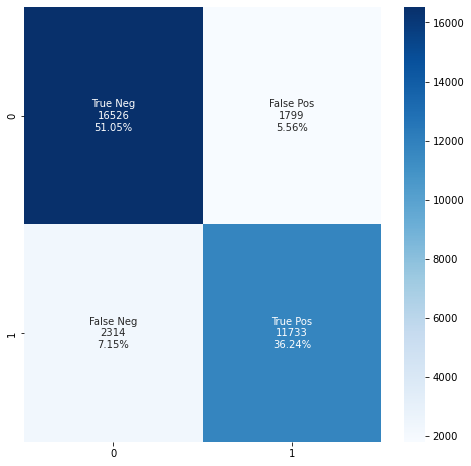

(array([0, 1, 0, ..., 1, 1, 0]),
 array([[0.98026785, 0.01973215],
        [0.15892137, 0.84107863],
        [0.7744488 , 0.2255512 ],
        ...,
        [0.19978532, 0.80021468],
        [0.08091171, 0.91908829],
        [0.94074667, 0.05925333]]))

In [36]:
# Run the LogisticRegression function defined above on our data.
LR(df_cat, 'satisfaction_v2')

Score train : 0.9999897027174529
Score test : 0.9667613987396515
R2 test : 0.8646824153293208


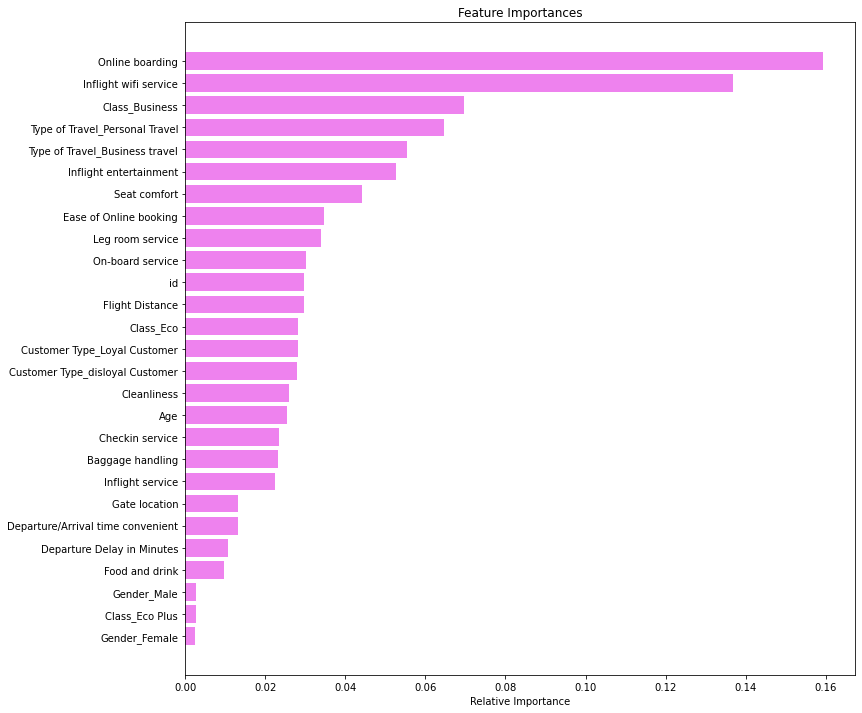

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18325
           1       0.98      0.95      0.96     14047

    accuracy                           0.97     32372
   macro avg       0.97      0.96      0.97     32372
weighted avg       0.97      0.97      0.97     32372

[[18012   313]
 [  763 13284]]


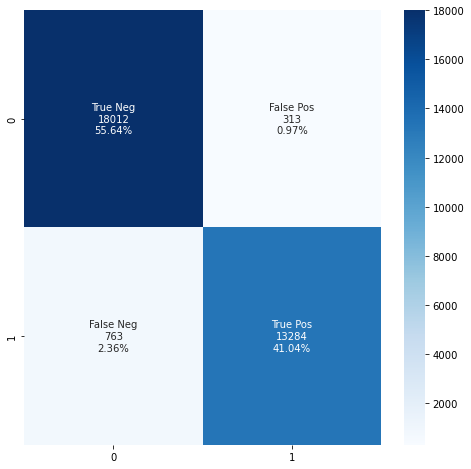

(RandomForestClassifier(), array([0, 1, 0, ..., 1, 1, 0]))

<Figure size 432x288 with 0 Axes>

In [37]:
# Run the RandomForest function defined above on our data (also runs the plot function).
forrests(df_cat, 'satisfaction_v2', 'n', 'n')

Our RandomForest model performed amazingly! There aren't many assumptions that we had to make either, since RandomForest models are non-parametric and can handle skewed data. Achieving a test score of 0.97 is something to be thrilled about, and so is a recall of 0.98 for the 0 class. In addition to this, many of the features we selected as important from our EDA showed up as some of the most important features for predicting customer satisfaction. Some of these include: online boarding, inflight wifi, inflight entertainment, personal travel, and class (business and economy). This model would be put to great use for our business needs. Although we could try some other models, this one performs near perfectly and is a simpler choice than most, so we will choose the RandomForest as our best model.